#  CMPE295 - Masters Project
## Abhishek Bais, Haley Feng, Princy Joy, Shannon Phu
## A Reinforcement-based Question-Answer Recommender System (RQAR)
## Team Equality

# Data Narrative
Community-based Question Answering (CBQA) platforms such as Reddit, Slack and Quora provide registered users a dedicated medium to post questions, crowdsource answers, find shared interest groups, and learn from each other. 

The goal of this project is to help CBQA platform users find answers to their questions.The RQAR oulined below is tailor made for the Reddit platform but designed in a modular fashion making it easily extendible to other CBQA platforms..

Reddit organizes its content into topic-based communities called “subreddits”. Users can find relevant communities using tools such as “r/FindAReddit” and join them to post questions and get community help on finding which subreddit to post to. However, with over 2,620,000 subreddits and an average of 60,251 new subreddits added to Reddit each month, finding the right community to join has become increasingly challenging.

To address this problem, a Reinforcement-based Question-Answer Recommender System (RQAR) is proposed to help CBQA users find relevant communities for their questions. This system will be used to extract context, group previously answered questions by similarity, learn from user interactions to find, rank, and recommend relevant communities to users.

# Factors
1. Semantic Similarity of posted question to historically answered questions
2. User feedback scores of historically answered questions  
3. Reinforced feedback from users to improved questions  


# 1.0. Read in datasets

## 1.1. Import packages to read-in data, nltk, sentiment analysis

In [ ]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=d659a2109dcab747d7abd136eb6233b0ba8c6e2473aa9558f3d66f52e5afa4d5
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built ml-metrics


In [ ]:
# Import standard libraries
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import requests
import ml_metrics as metrics

# Import NLP libraries
import re
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

# Import Sentiment Analysis packages
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Import time libs
import time
import os

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


## 1.2. Read in historical question answer pairs


In [ ]:
path = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/2. Data Cleaning/data/train_QA_with_topic.csv'
df_QA = pd.read_csv(path)
df_QA = df_QA.drop(columns=['comment_id'])
df_QA = df_QA.drop_duplicates()
df_QA

,question_id,question,question_vocab,comment_upvotes,suggested_subreddits,LDA_topic,LDA_Vocab
0,eib8be,Looking for a subreddit about redundancy (sort...,looking redundancy sort place good idealess wo...,2,r/antiwork,6,work tip job advice learn
1,eibax6,ideas for playing/teaching toddlers,idea teaching toddler 3 year old brother alway...,1,r/kidscrafts,7,year friend family life parent
2,eibax6,ideas for playing/teaching toddlers,idea teaching toddler 3 year old brother alway...,1,r/toddlers,7,year friend family life parent
3,eibax6,ideas for playing/teaching toddlers,idea teaching toddler 3 year old brother alway...,1,r/kidsafevideos,7,year friend family life parent
4,eibcq9,I need a subreddit where I can ask legal quest...,need legal question regarding tech general one...,1,r/entrepreneur,6,work tip job advice learn
...,...,...,...,...,...,...,...
80547,o0oakk,A subreddit to make actual online friends?,make actual friend title,2,r/penpals,8,place make dont love person
80548,o0oakk,A subreddit to make actual online friends?,make actual friend title,1,r/makenewfriendshere,8,place make dont love person
80549,o0ox9h,What sub for questions about terms and conditions,question term condition video make directed di...,1,r/legaladviceofftopic,12,comment funny share thought posting
80550,o0pibq,A sub where people can draw plans for my garden,draw plan garden landscape rubbish thinking id...,2,r/howto,2,video game remember show movie


In [ ]:
with pd.option_context('display.max_columns', None, "display.max_rows", None, 'display.max_colwidth', None):
  display(df_QA[df_QA['question_id'] == 'o0oakk'])

,question_id,question,question_vocab,comment_upvotes,suggested_subreddits,LDA_topic,LDA_Vocab
80547,o0oakk,A subreddit to make actual online friends?,make actual friend title,2,r/penpals,8,place make dont love person
80548,o0oakk,A subreddit to make actual online friends?,make actual friend title,1,r/makenewfriendshere,8,place make dont love person


## 1.3. Create training and validation datasets

In [ ]:
# import random 
# random.seed(0)
# question_id = df_QA['question_id'].tolist()
# question_id = list(np.unique(question_id))

# val_size = 0.2
# val_question_id = random.sample(question_id, round(len(question_id)*val_size))
# train_question_id = list(set(question_id) - set(val_question_id))

# df_QA_train = df_QA[df_QA['question_id'].isin(train_question_id)].reset_index(drop=True)
# df_QA_val = df_QA[df_QA['question_id'].isin(val_question_id)].reset_index(drop=True)

# print("Training size:", len(train_question_id)) # Distinct
# print("Validation size:", len(val_question_id))

# path = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/datasets/train.csv'
# df_QA_train.to_csv(path, index=False)

# path = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/datasets/validation.csv'
# df_QA_val.to_csv(path, index=False)

In [ ]:
path = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/datasets/train.csv'
df_QA_train = pd.read_csv(path)

path = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/datasets/validation.csv'
df_QA_val = pd.read_csv(path)

#Full question only
# corpus = df_QA_train['question'].tolist()
# corpus = list(np.unique(corpus))

# Question vocab
corpus = df_QA_train['question_vocab'].tolist()
corpus = list(np.unique(corpus))

## 1.4. Data preparation for nlp tasks

Tasks include:
1. Removing number, punctuations, stop words, duplicates
2. Lemmatization and stemming
3. Expanding contractions

In [ ]:
def normalize_text(text):
        toko_tokenizer = ToktokTokenizer()
        wordnet_lemmatizer = WordNetLemmatizer()
        puncts = ['/', ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
         '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
         '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
         '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
         '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

        def clean_text(text):
            text = str(text)
            text = text.replace('\n', '')
            text = text.replace('\r', '')
            text = text.replace('/', ' ')
            for punct in puncts:
                if punct in text:
                    text = text.replace(punct, '')
            return text.lower()

        def remove_duplicates(text):
            text = text.split(" ")
            for i in range(0, len(text)):
                text[i] = "".join(text[i])
            UniqW = Counter(text)
            text = " ".join(UniqW.keys())
            return text

        def clean_numbers(text):
            if bool(re.search(r'\d', text)):
                text = re.sub('[0-9]{5,}', '#####', text)
                text = re.sub('[0-9]{4}', '####', text)
                text = re.sub('[0-9]{3}', '###', text)
                text = re.sub('[0-9]{2}', '##', text)
            return text

        contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

        def _get_contractions(contraction_dict):
            contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
            return contraction_dict, contraction_re

        contractions, contractions_re = _get_contractions(contraction_dict)

        def replace_contractions(text):
            def replace(match):
                return contractions[match.group(0)]
            return contractions_re.sub(replace, text)

        def remove_stopwords(text, is_lower_case=True):
            stop_words = stopwords.words('english')
            stop_words.extend(['subreddit', 'subreddits', 'reddit', 'sub', 'nan']) # Remove reddit related words
            stop_words.extend(['question','like', 'post', 'find', 'finding', 'help', 'want', 'look', 'ask', 'people', 'something', 'thing', 'community', 'talk']) # Remove helper words
            stop_words.extend(['http', 'com', 'ww']) # Remove link
            tokens = toko_tokenizer.tokenize(text)
            tokens = [token.strip() for token in tokens]
            if is_lower_case:
                filtered_tokens = [token for token in tokens if token not in stop_words]
            else:
                filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
            filtered_text = ' '.join(filtered_tokens)    
            return filtered_text

        def lemmatizer(text):
            tokens = toko_tokenizer.tokenize(text)
            tokens = [token.strip() for token in tokens]
            tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
            return ' '.join(tokens)

        def trim_text(text):
            tokens = toko_tokenizer.tokenize(text)
            tokens = [token.strip() for token in tokens]
            return ' '.join(tokens)

        text_norm = clean_text(text)
        text_norm = remove_duplicates(text_norm)
        text_norm = clean_numbers(text_norm)
        text_norm = replace_contractions(text_norm)
        text_norm = remove_stopwords(text_norm)
        text_norm = lemmatizer(text_norm)
        text_norm = trim_text(text_norm)
        return text_norm

## 1.5 Topic Modeling

###1.5.1. LDA to train

In [ ]:
df_QA_train['question+lda'] = df_QA_train['question'] + df_QA_train['LDA_Vocab']
df_QA_train['question_vocab+lda'] = df_QA_train['question_vocab'] + df_QA_train['LDA_Vocab']

df_QA_val['question+lda'] = df_QA_val['question'] + df_QA_val['LDA_Vocab']
df_QA_val['question_vocab+lda'] = df_QA_val['question_vocab'] + df_QA_val['LDA_Vocab']

corpus = df_QA_train['question_vocab+lda'].tolist()
corpus = list(np.unique(corpus))

###1.5.2 LDA for inference

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

In [ ]:
# source: https://medium.com/analytics-vidhya/mallet-machine-learning-for-language-toolkit-installation-on-google-colaboratory-80b75fe486cb
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-10-01 22:46:26--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  14.5MB/s    in 1.1s    

2021-10-01 22:46:27 (14.5 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8' 

In [ ]:
def load_lda():

  # 1. Load saved LDA model
  ldaMallet = gensim.models.wrappers.LdaMallet.load("/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/2. Data Cleaning/LDA file/lda_model.model")
  ldaModel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldaMallet)

  # 2. Get topic vocab
  topic_vocab = {}
  for n in range(0, 15):
    vocabs = ''
    for term, wt in ldaMallet.show_topic(n, topn=5): # Consider only top 5 words to represent the topics
      vocabs += ' ' + term
    topic_vocab[n] = vocabs

  return ldaModel, topic_vocab

In [ ]:
ldaModel, topic_vocab = load_lda()

In [ ]:
def lda_inference(text):

  # 1. Preprocess to LDA format
  lda_words = [[word for word in simple_preprocess(text)]]
  lda_dictionary_path = "/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/2. Data Cleaning/LDA file/lda_dictionary.txt"
  id2word = corpora.Dictionary.load_from_text(lda_dictionary_path)
  corpus = [id2word.doc2bow(word) for word in lda_words]

  # 2. Compute topic inference and append to question
  topic_num = sorted(ldaModel[corpus[0]], key=lambda tup: -1*tup[1])[0][0]
  text_lda = text + topic_vocab.get(topic_num)

  return text_lda

In [ ]:
lda_inference("a sub to get advice about applying for master")

'a sub to get advice about applying for master work tip job advice learn'

### 1.5.3. LDA visualization

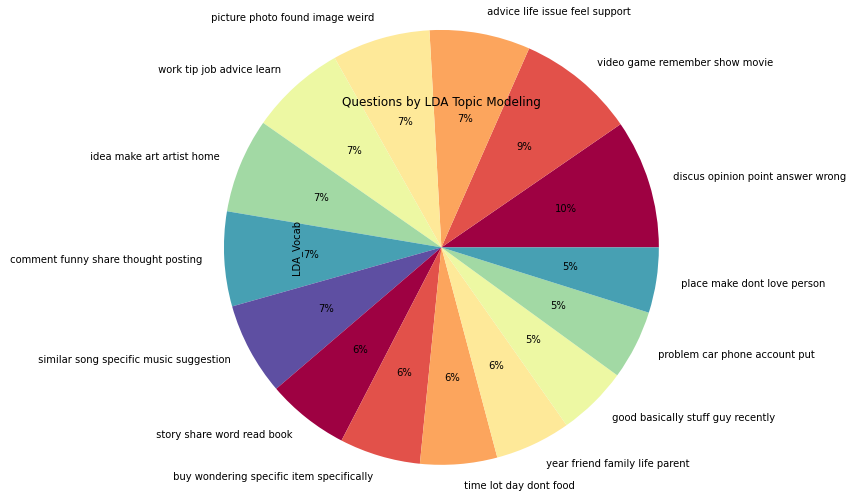

In [ ]:
# Report historically answered questions by question topic
plt.figure(figsize=(15,5), edgecolor='b')
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
df_QA['LDA_Vocab'].value_counts().plot(kind="pie", radius=2.0, autopct='%1.0f%%', colors=colors)
plt.title('Questions by LDA Topic Modeling')
plt.show()

# 2.0. Embedding and Semantic Similarity

## 2.1. Initial Sentence Transformers Installation
1. [BERT cased baseline](https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens): Encode questions into an array of size (768,)
2. [multi-qa-MiniLM-L6-cos-v1](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1): maps sentences & paragraphs to a 384 dimensional dense vector space and was designed for semantic search. It has been trained on 215M (question, answer) pairs from diverse sources



In [ ]:
pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.3 MB/s 
     |████████████████████████████████| 2.9 MB 11.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.1 MB/s 
     |████████████████████████████████| 1.2 MB 38.7 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 895 kB 47.8 MB/s 
     |████████████████████████████████| 636 kB 51.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=47c1c139dd6c8959885ea077d5513d65244416c1443379952b1a2aa61bc16c4f
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
import scipy.spatial

In [ ]:
%%time
embedder = SentenceTransformer('bert-base-nli-mean-tokens')
# embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

CPU times: user 14.5 s, sys: 2.99 s, total: 17.5 s
Wall time: 22.5 s


In [ ]:
corpus_embeddings = embedder.encode(corpus)

Load old embedding instead of encoding

In [ ]:
# import pickle
# with open('/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/pickled_embeddings/corpus_embeddings.pickle','wb') as data_file:
#      pickle.dump(corpus_embeddings, data_file)

with open('/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/pickled_embeddings/corpus_embeddings.pickle','rb') as data_file:
     corpus_embeddings = pickle.load(data_file)

## 2.2. Export embedding for visualization in Embedding Projector

In [ ]:
# Convert NumPy array of embedding into data frame
embedding_df = pd.DataFrame(corpus_embeddings)

# Save dataframe as as TSV file without any index and header
embedding_df.to_csv('/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/pickled_embeddings/embeddings_output.tsv', sep='\t', index=None, header=None)

# Save dataframe without any index
df_QA.to_csv('/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/pickled_embeddings/embeddings_metadata.tsv', index=False, sep='\t')

## 2.3. Visualize the embeddings in Embedding Projector 

[Embedding Projector Visualizations](https://projector.tensorflow.org/)

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

## 2.4 Visualize Embedding Projector in tensorboard
[Embedding Projector visualization in tensorboard](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin)

## 2.5. Faiss
- source: https://github.com/kavetinaveen/Deep-Learning-for-Semantic-Text-Matching/blob/main/NLP%20using%20Deep%20Learning%20in%20Python.ipynb
- faiss: https://github.com/facebookresearch/faiss

In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-cpu
!python -m pip install --upgrade faiss faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (253 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [ ]:
import faiss
# index = faiss.IndexFlatL2(768)
index = faiss.IndexFlatL2(corpus_embeddings.shape[1])
print(index.is_trained)
index.add(np.stack(corpus_embeddings, axis=0))
print(index.ntotal)


True
26777


Serialise index and store it as a pickle

In [ ]:
# import pickle
# project_dir = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/3. Model Notebook/pickled_RQAR_models/faiss_index.pickle'
# with open(project_dir, "wb") as h:
#     pickle.dump(faiss.serialize_index(index), h)
# with open(project_dir, "rb") as h:
#      index_pickled = faiss.deserialize_index(pickle.load(h))

# 3.0. Recommandation System 


## 3.1. Rank answer utility APIs
Weighted Sum Method
*   Normalize Euclidean Distance
*   Min-Max Normalize upvotes
*   Number of Occurence among similar questions

In [ ]:
def RQAR(new_question, num_rec, embedder, df, question_type, lda=False, compress=False):

  """
  Attributes
  ----------
  new_question : str
      Question to search for subreddit
  num_rec : int
      Number of related question to search for (does not equal to the total subreddits return)
  embedder : framework
      Encode new question with pre-trained model
  df : dataframe
      Dataframe used for embedder
  question_type : str
      Denote dataframe column name either as "question" or "question_vocab"
  lda : boolean
      Additional amalgamation with LDA topic modeling (embedder must be trained with question with LDA)
  """

  # 0. Preprocess question and add topic inference
  new_question = normalize_text(new_question)
  if lda == True:
    new_quesiton = lda_inference(new_question)

  # 1. Encode question and find relevant doc
  quest_embed = embedder.encode(new_question)
  distances, indices = index.search(np.asarray(quest_embed).reshape(1,quest_embed.shape[0]),num_rec)
  L2_distance = distances[0] 
  norm_L2_distance = L2_distance/np.linalg.norm(L2_distance) # scale distance to [0, 1]
  relevant_docs = [corpus[indices[0,idx]] for idx in range(num_rec)]

  # 2. Create a new dataframe for suggestion
  relevant = pd.DataFrame({'relevant_question':relevant_docs, 'semantic_similarity':norm_L2_distance})
  relevant_subreddit = relevant.merge(df, left_on='relevant_question', right_on=question_type, how='inner')
  if lda == True:
    relevant_subreddit = relevant_subreddit[['relevant_question', 'LDA_Vocab' ,'suggested_subreddits', 'semantic_similarity', 'comment_upvotes']]
  else: 
    relevant_subreddit = relevant_subreddit[['relevant_question','suggested_subreddits', 'semantic_similarity', 'comment_upvotes']]

  # 3. Calculate total weight by combining upvotes, occurrences, similarity
  relevant_subreddit['occurrence'] = relevant_subreddit.groupby('suggested_subreddits')['suggested_subreddits'].transform('count')
  relevant_subreddit['norm_upvotes'] = (relevant_subreddit['comment_upvotes']-relevant_subreddit['comment_upvotes'].min())/(relevant_subreddit['comment_upvotes'].max()-relevant_subreddit['comment_upvotes'].min())
  # Polynomial method, tune to optimize result
  relevant_subreddit['total_weight'] = 0.75*(1 - relevant_subreddit['semantic_similarity']) + 0.10*relevant_subreddit['norm_upvotes'] + 0.15*(relevant_subreddit['occurrence']/num_rec)

  # TODO: Investigate why rows have null predictions. For now, drop rows with null predictions
  # Investigate using:
  # val_questions[(val_questions['predictions'].str.len() == 0) | (val_questions['labels'].str.len() == 0)]
  relevant_subreddit = relevant_subreddit[relevant_subreddit['total_weight'].notnull()]

  relevant_subreddit = relevant_subreddit.drop_duplicates(subset='suggested_subreddits').sort_values(by='total_weight', ascending=False).reset_index(drop=True)
  
  if compress:
    return list(map(tuple, relevant_subreddit[['suggested_subreddits', 'total_weight']].values.tolist()))
  else:
    return relevant_subreddit

In [ ]:
def _get_scores_and_labels_for_ndcg(predictions, labels):
  d = {}
  for subreddit, score in predictions:
    d[subreddit] = [score, 0]
  for subreddit, label in labels:
    if subreddit not in d:
      d[subreddit] = [0, label]
    else:
      d[subreddit][1] = label
  
  scores = [[v[0] for _, v in d.items()]]
  true_relevance = [[v[1] for _, v in d.items()]]
  return scores, true_relevance

def _get_scores_and_labels_for_map(predictions, labels):
  d = {}
  for subreddit, score in predictions:
    d[subreddit] = [score, 0]
  for subreddit, label in labels:
    if subreddit not in d:
      d[subreddit] = [0, label]
    else:
      d[subreddit][1] = label
  
  scores = [[k[0] for k in predictions]]
  true_relevance = [[k[0] for k in labels]]
  return scores, true_relevance

def compute_ndcg(predictions, labels, k):
  scores, true_relevance = _get_scores_and_labels_for_ndcg(predictions, labels)
  return ndcg_score(true_relevance, scores, k=k)

def compute_map(predictions, labels, k):
  scores, true_relevance = _get_scores_and_labels_for_map(predictions, labels)
  return metrics.mapk(true_relevance, scores, k=k)

##3.2. Evaluate rank with full question

In [ ]:
val_questions = df_QA_val[['question']].drop_duplicates()[:500]
val_questions['predictions'] = val_questions.apply(lambda q: RQAR(q, 10, embedder, df_QA_train, 'question', compress=True), axis=1)

true_labels = df_QA_val.groupby('question')[['suggested_subreddits', 'comment_upvotes']].apply(lambda g: list(map(tuple, g.values.tolist()))).reset_index()
true_labels.columns = ['question', 'labels']

val_questions = val_questions.merge(true_labels, on='question')

eval_questions = val_questions[(val_questions['predictions'].str.len() > 0) & (val_questions['labels'].str.len() > 0)].copy()
ks = [50, 20, 10, 5, 1]
for k in ks:
  eval_questions[f'ndcg@{k}'] = eval_questions.apply(lambda r: compute_ndcg(r['predictions'], r['labels'], k), axis=1)
  eval_questions[f'map@{k}'] = eval_questions.apply(lambda r: compute_map(r['predictions'], r['labels'], k), axis=1)
  print(f'Overall NDCG@{k}:', float(eval_questions[f'ndcg@{k}'].mean()))
  print(f'Overall MAP@{k}:', float(eval_questions[f'map@{k}'].mean()))

Overall NDCG@50: 0.32123134157723243
Overall MAP@50: 0.0669912975014754
Overall NDCG@20: 0.19062223032637468
Overall MAP@20: 0.06611105117552332
Overall NDCG@10: 0.098672959965986
Overall MAP@10: 0.06470012292234514
Overall NDCG@5: 0.07638774224084836
Overall MAP@5: 0.057699214365881026
Overall NDCG@1: 0.06437628977951558
Overall MAP@1: 0.06666666666666667


## 3.3 Evaluate rank with LDA topic

In [ ]:
full_question_lda_RQAR = RQAR("Online dating reddit?", 10, embedder, df_QA_train, 'question+lda', True)
full_question_lda_RQAR.head()

,relevant_question,LDA_Vocab,suggested_subreddits,semantic_similarity,comment_upvotes,occurrence,norm_upvotes,total_weight
0,A subreddit for intentionally bad design (for ...,comment funny share thought posting,r/atbge,0.193463,4,1,0.375,0.657403
1,A subreddit for just saying something you are ...,discus opinion point answer wrong,r/congratslikeimfive,0.278466,9,1,1.000,0.656150
2,A subreddit for just saying something you are ...,discus opinion point answer wrong,r/accomplishedtoday,0.278466,9,1,1.000,0.656150
3,A subreddit for just saying something you are ...,discus opinion point answer wrong,r/casualconversation,0.278466,9,1,1.000,0.656150
4,A subreddit for intentionally bad design (for ...,comment funny share thought posting,r/baduibattles,0.193463,3,1,0.250,0.644903


In [ ]:
val_questions = df_QA_val[['question']].drop_duplicates()[:500]
val_questions['predictions'] = val_questions.apply(lambda q: RQAR(q, 10, embedder, df_QA_train, 'question+lda', lda=True, compress=True), axis=1)

true_labels = df_QA_val.groupby('question')[['suggested_subreddits', 'comment_upvotes']].apply(lambda g: list(map(tuple, g.values.tolist()))).reset_index()
true_labels.columns = ['question', 'labels']

val_questions = val_questions.merge(true_labels, on='question')

eval_questions = val_questions[(val_questions['predictions'].str.len() > 0) & (val_questions['labels'].str.len() > 0)].copy()
ks = [50, 20, 10, 5, 1]
for k in ks:
  eval_questions[f'ndcg@{k}'] = eval_questions.apply(lambda r: compute_ndcg(r['predictions'], r['labels'], k), axis=1)
  eval_questions[f'map@{k}'] = eval_questions.apply(lambda r: compute_map(r['predictions'], r['labels'], k), axis=1)
  print(f'Overall NDCG@{k}:', float(eval_questions[f'ndcg@{k}'].mean()))
  print(f'Overall MAP@{k}:', float(eval_questions[f'map@{k}'].mean()))

Overall NDCG@50: 0.2221866564868834
Overall MAP@50: 0.041436263930171066
Overall NDCG@20: 0.13545670812830818
Overall MAP@20: 0.04061335196866545
Overall NDCG@10: 0.06251095672676814
Overall MAP@10: 0.03874055555555554
Overall NDCG@5: 0.047907592259872914
Overall MAP@5: 0.03300888888888889
Overall NDCG@1: 0.03633333333333333
Overall MAP@1: 0.038


##3.4 Evaluate rank with cleaned question 

In [ ]:
cleaned_question_RQAR = RQAR("sub related to playing games with friends?", 10, embedder, df_QA_train, 'question_vocab', lda=False, compress=False)
cleaned_question_RQAR.head()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


,relevant_question,suggested_subreddits,semantic_similarity,comment_upvotes,occurrence,norm_upvotes,total_weight
0,friend play game,r/gamerpals,0.154238,1,5,0.0,0.709321
1,type friend play,r/playdate,0.207218,1,3,0.0,0.639586
2,finding friend game preferably switch,r/switchfcswap,0.337251,2,1,1.0,0.612062
3,type friend play,r/lfg,0.207218,1,1,0.0,0.609586
4,looking search game play friend,r/games,0.233534,1,1,0.0,0.589849


In [ ]:
val_questions = df_QA_val[['question_vocab']].drop_duplicates()[:500]
val_questions['predictions'] = val_questions.apply(lambda q: RQAR(q, 10, embedder, df_QA_train, 'question_vocab', lda=False, compress=True), axis=1)

true_labels = df_QA_val.groupby('question_vocab')[['suggested_subreddits', 'comment_upvotes']].apply(lambda g: list(map(tuple, g.values.tolist()))).reset_index()
true_labels.columns = ['question_vocab', 'labels']

val_questions = val_questions.merge(true_labels, on='question_vocab')

eval_questions = val_questions[(val_questions['predictions'].str.len() > 0) & (val_questions['labels'].str.len() > 0)].copy()
ks = [50, 20, 10, 5, 1]
for k in ks:
  eval_questions[f'ndcg@{k}'] = eval_questions.apply(lambda r: compute_ndcg(r['predictions'], r['labels'], k), axis=1)
  eval_questions[f'map@{k}'] = eval_questions.apply(lambda r: compute_map(r['predictions'], r['labels'], k), axis=1)
  print(f'Overall NDCG@{k}:', float(eval_questions[f'ndcg@{k}'].mean()))
  print(f'Overall MAP@{k}:', float(eval_questions[f'map@{k}'].mean()))

Overall NDCG@50: 0.32426924431860177
Overall MAP@50: 0.0782119598251192
Overall NDCG@20: 0.21211957597595144
Overall MAP@20: 0.07741598661400523
Overall NDCG@10: 0.10828220607702319
Overall MAP@10: 0.0729693650793651
Overall NDCG@5: 0.08846167726282106
Overall MAP@5: 0.0657261111111111
Overall NDCG@1: 0.07339999999999999
Overall MAP@1: 0.074


## 3.5 Evaluate ranking for cleaned question + LDA

In [ ]:
cleaned_question_RQAR = RQAR("sub for minecraft related?", 10, embedder, df_QA_train, 'question_vocab+lda', True)
cleaned_question_RQAR.head()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


,relevant_question,LDA_Vocab,suggested_subreddits,semantic_similarity,comment_upvotes,occurrence,norm_upvotes,total_weight
0,limitation buy wondering specific item specifi...,buy wondering specific item specifically,r/askreddit,0.303980,2,1,1.0,0.637015
1,talk metal buy wondering specific item specifi...,buy wondering specific item specifically,r/metallurgy,0.307483,2,1,1.0,0.634388
2,sub one serve purpose another name buy wonderi...,buy wondering specific item specifically,r/subredditname,0.311629,2,1,1.0,0.631278
3,sub one serve purpose another name buy wonderi...,buy wondering specific item specifically,r/findasubreddit,0.311629,2,1,1.0,0.631278
4,thing old tool anything buy wondering specific...,buy wondering specific item specifically,r/restorationporn,0.312030,2,1,1.0,0.630978


In [ ]:
val_questions = df_QA_val[['question_vocab+lda']].drop_duplicates()[:500]
val_questions['predictions'] = val_questions.apply(lambda q: RQAR(q, 10, embedder, df_QA_train, 'question_vocab+lda', lda=False, compress=True), axis=1)

true_labels = df_QA_val.groupby('question_vocab+lda')[['suggested_subreddits', 'comment_upvotes']].apply(lambda g: list(map(tuple, g.values.tolist()))).reset_index()
true_labels.columns = ['question_vocab+lda', 'labels']

val_questions = val_questions.merge(true_labels, on='question_vocab+lda')

eval_questions = val_questions[(val_questions['predictions'].str.len() > 0) & (val_questions['labels'].str.len() > 0)].copy()
ks = [50, 20, 10, 5, 1]
for k in ks:
  eval_questions[f'ndcg@{k}'] = eval_questions.apply(lambda r: compute_ndcg(r['predictions'], r['labels'], k), axis=1)
  eval_questions[f'map@{k}'] = eval_questions.apply(lambda r: compute_map(r['predictions'], r['labels'], k), axis=1)
  print(f'Overall NDCG@{k}:', float(eval_questions[f'ndcg@{k}'].mean()))
  print(f'Overall MAP@{k}:', float(eval_questions[f'map@{k}'].mean()))

Overall NDCG@50: 0.3141631270618493
Overall MAP@50: 0.06841389761934362
Overall NDCG@20: 0.1937214128001524
Overall MAP@20: 0.06756271200954686
Overall NDCG@10: 0.093304852174441
Overall MAP@10: 0.0639082662679857
Overall NDCG@5: 0.07579887404076767
Overall MAP@5: 0.05721387218882209
Overall NDCG@1: 0.05568946751311481
Overall MAP@1: 0.05811623246492986


## 3.6 Plot Metrics from Various Experiments

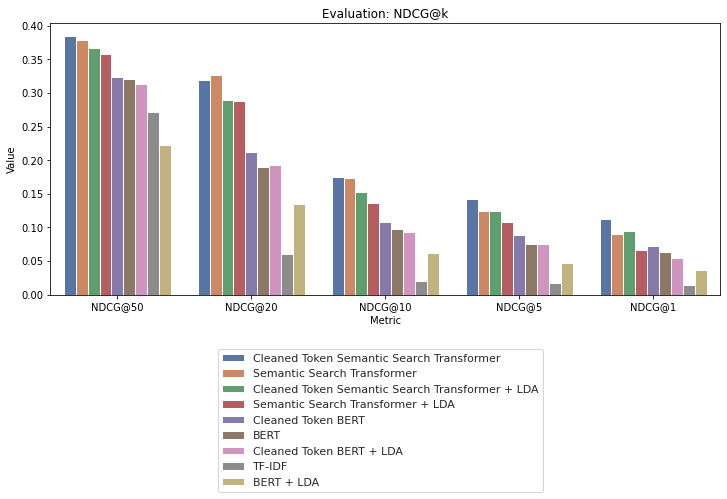

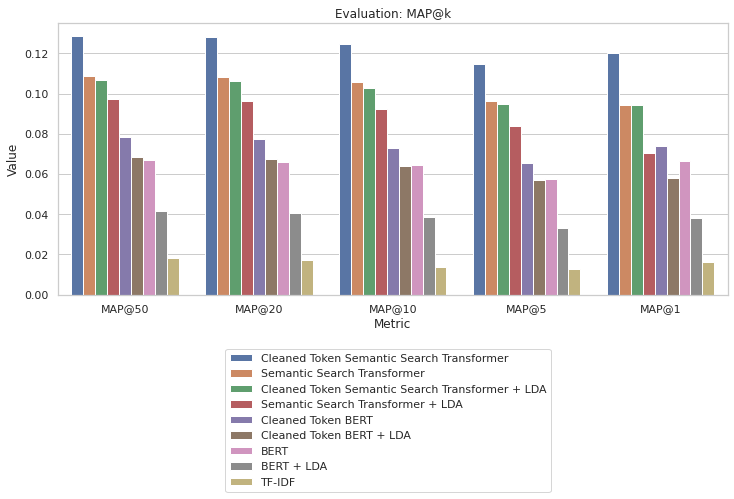

In [ ]:
experiment_ndcg_metrics = pd.DataFrame([
  ['TF-IDF', 'NDCG@50', 50, 0.271],
  ['TF-IDF', 'NDCG@20', 20, 0.060],
  ['TF-IDF', 'NDCG@10', 10, 0.020],
  ['TF-IDF', 'NDCG@5', 5, 0.017],
  ['TF-IDF', 'NDCG@1', 1, 0.015],

  ['BERT', 'NDCG@50', 50, 0.321],
  ['BERT', 'NDCG@20', 20, 0.190],
  ['BERT', 'NDCG@10', 10, 0.098],
  ['BERT', 'NDCG@5', 5, 0.076],
  ['BERT', 'NDCG@1', 1, 0.064],

  ['BERT + LDA', 'NDCG@50', 50, 0.222],
  ['BERT + LDA', 'NDCG@20', 20, 0.135],
  ['BERT + LDA', 'NDCG@10', 10, 0.062],
  ['BERT + LDA', 'NDCG@5', 5, 0.047],
  ['BERT + LDA', 'NDCG@1', 1, 0.036],

  ['Cleaned Token BERT', 'NDCG@50', 50, 0.324],
  ['Cleaned Token BERT', 'NDCG@20', 20, 0.212],
  ['Cleaned Token BERT', 'NDCG@10', 10, 0.108],
  ['Cleaned Token BERT', 'NDCG@5', 5, 0.088],
  ['Cleaned Token BERT', 'NDCG@1', 1, 0.073],

  ['Cleaned Token BERT + LDA', 'NDCG@50', 50, 0.314],
  ['Cleaned Token BERT + LDA', 'NDCG@20', 20, 0.193],
  ['Cleaned Token BERT + LDA', 'NDCG@10', 10, 0.093],
  ['Cleaned Token BERT + LDA', 'NDCG@5', 5, 0.075],
  ['Cleaned Token BERT + LDA', 'NDCG@1', 1, 0.055],

  ['Semantic Search Transformer', 'NDCG@50', 50, 0.378],
  ['Semantic Search Transformer', 'NDCG@20', 20, 0.326],
  ['Semantic Search Transformer', 'NDCG@10', 10, 0.173],
  ['Semantic Search Transformer', 'NDCG@5', 5, 0.125],
  ['Semantic Search Transformer', 'NDCG@1', 1, 0.090],

  ['Semantic Search Transformer + LDA', 'NDCG@50', 50, 0.358],
  ['Semantic Search Transformer + LDA', 'NDCG@20', 20, 0.288],
  ['Semantic Search Transformer + LDA', 'NDCG@10', 10, 0.137],
  ['Semantic Search Transformer + LDA', 'NDCG@5', 5, 0.108],
  ['Semantic Search Transformer + LDA', 'NDCG@1', 1, 0.066],

  ['Cleaned Token Semantic Search Transformer', 'NDCG@50', 50, 0.385],
  ['Cleaned Token Semantic Search Transformer', 'NDCG@20', 20, 0.319],
  ['Cleaned Token Semantic Search Transformer', 'NDCG@10', 10, 0.175],
  ['Cleaned Token Semantic Search Transformer', 'NDCG@5', 5, 0.142],
  ['Cleaned Token Semantic Search Transformer', 'NDCG@1', 1, 0.112],

  ['Cleaned Token Semantic Search Transformer + LDA', 'NDCG@50', 50, 0.367],
  ['Cleaned Token Semantic Search Transformer + LDA', 'NDCG@20', 20, 0.289],
  ['Cleaned Token Semantic Search Transformer + LDA', 'NDCG@10', 10, 0.152],
  ['Cleaned Token Semantic Search Transformer + LDA', 'NDCG@5', 5, 0.125],
  ['Cleaned Token Semantic Search Transformer + LDA', 'NDCG@1', 1, 0.094],
], columns=['Experiment', 'Metric', 'k', 'Value'])

experiment_map_metrics = pd.DataFrame([
  ['TF-IDF', 'MAP@50', 50, 0.018],
  ['TF-IDF', 'MAP@20', 20, 0.017],
  ['TF-IDF', 'MAP@10', 10, 0.014],
  ['TF-IDF', 'MAP@5', 5, 0.013],
  ['TF-IDF', 'MAP@1', 1, 0.016],

  ['BERT', 'MAP@50', 50, 0.06699],
  ['BERT', 'MAP@20', 20, 0.06611],
  ['BERT', 'MAP@10', 10, 0.06470],
  ['BERT', 'MAP@5', 5, 0.05769],
  ['BERT', 'MAP@1', 1, 0.06666],

  ['BERT + LDA', 'MAP@50', 50, 0.04143],
  ['BERT + LDA', 'MAP@20', 20, 0.04061],
  ['BERT + LDA', 'MAP@10', 10, 0.03874],
  ['BERT + LDA', 'MAP@5', 5, 0.03300],
  ['BERT + LDA', 'MAP@1', 1, 0.038],

  ['Cleaned Token BERT', 'MAP@50', 50, 0.07821],
  ['Cleaned Token BERT', 'MAP@20', 20, 0.07741],
  ['Cleaned Token BERT', 'MAP@10', 10, 0.07296],
  ['Cleaned Token BERT', 'MAP@5', 5, 0.06572],
  ['Cleaned Token BERT', 'MAP@1', 1, 0.074],

  ['Cleaned Token BERT + LDA', 'MAP@50', 50, 0.06841],
  ['Cleaned Token BERT + LDA', 'MAP@20', 20, 0.06756],
  ['Cleaned Token BERT + LDA', 'MAP@10', 10, 0.06390],
  ['Cleaned Token BERT + LDA', 'MAP@5', 5, 0.05721],
  ['Cleaned Token BERT + LDA', 'MAP@1', 1, 0.05811],

  ['Semantic Search Transformer', 'MAP@50', 50, 0.10886],
  ['Semantic Search Transformer', 'MAP@20', 20, 0.10828],
  ['Semantic Search Transformer', 'MAP@10', 10, 0.10573],
  ['Semantic Search Transformer', 'MAP@5', 5, 0.09616],
  ['Semantic Search Transformer', 'MAP@1', 1, 0.094567],

  ['Semantic Search Transformer + LDA', 'MAP@50', 50, 0.09749],
  ['Semantic Search Transformer + LDA', 'MAP@20', 20, 0.09631],
  ['Semantic Search Transformer + LDA', 'MAP@10', 10, 0.09230],
  ['Semantic Search Transformer + LDA', 'MAP@5', 5, 0.08414],
  ['Semantic Search Transformer + LDA', 'MAP@1', 1, 0.07042],

  ['Cleaned Token Semantic Search Transformer', 'MAP@50', 50, 0.12880],
  ['Cleaned Token Semantic Search Transformer', 'MAP@20', 20, 0.12804],
  ['Cleaned Token Semantic Search Transformer', 'MAP@10', 10, 0.12456],
  ['Cleaned Token Semantic Search Transformer', 'MAP@5', 5, 0.11459],
  ['Cleaned Token Semantic Search Transformer', 'MAP@1', 1, 0.12024],

  ['Cleaned Token Semantic Search Transformer + LDA', 'MAP@50', 50, 0.10697],
  ['Cleaned Token Semantic Search Transformer + LDA', 'MAP@20', 20, 0.106419],
  ['Cleaned Token Semantic Search Transformer + LDA', 'MAP@10', 10, 0.10270],
  ['Cleaned Token Semantic Search Transformer + LDA', 'MAP@5', 5, 0.09461],
  ['Cleaned Token Semantic Search Transformer + LDA', 'MAP@1', 1, 0.09456],
], columns=['Experiment', 'Metric', 'k', 'Value'])

fig, ax = plt.subplots(figsize=(12,5))
sns.set_theme(style="whitegrid")
sns.barplot(x="Metric", y="Value", hue="Experiment", data=experiment_ndcg_metrics.sort_values(by=['k','Value'], ascending=False), ax=ax).set(title='Evaluation: NDCG@k')
plt.legend(bbox_to_anchor=(0.25, -0.2), loc=2, borderaxespad=0.)
plt.show()

fig, ax = plt.subplots(figsize=(12,5))
sns.set_theme(style="whitegrid")
sns.barplot(x="Metric", y="Value", hue="Experiment", data=experiment_map_metrics.sort_values(by=['k', 'Value'], ascending=False), ax=ax).set(title='Evaluation: MAP@k')
plt.legend(bbox_to_anchor=(0.25, -0.2), loc=2, borderaxespad=0.)
plt.show()

# 4.0. Reinforcement based question improvement using 
1. [T5 - Text to text transformer](https://paperswithcode.com/method/t5)  
2. [Parrot - Paraphraser based on utterance augmentation](https://pythonrepo.com/repo/PrithivirajDamodaran-Parrot-python-natural-language-processing) 
3. [Azure Personalizer RL agents](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/quickstart-personalizer-sdk?pivots=programming-language-python)

**T5, or Text-to-Text Transfer Transformer**, is a Transformer based architecture that uses a text-to-text approach. Every task – including translation, question answering, and classification – is cast as feeding the model text as input and training it to generate some target text. This allows for the use of the same model, loss function, hyperparameters, etc. across our diverse set of tasks. The changes compared to BERT include   
i.  Adding a causal decoder to the bidirectional architecture.  
ii. Replacing the fill-in-the-blank cloze task with a mix of alternative pre-training tasks.

**Parrot is a paraphrase based utterance augmentation framework** purpose built to accelerate training NLU models. 
3 key metrics that measures the quality of paraphrases are:  
i.   Adequacy (Is the meaning preserved adequately?)  
ii.  Fluency (Is the paraphrase fluent English?)  
iii. Diversity (Lexical / Phrasal / Syntactical) (How much has the paraphrase changed the original sentence?)  
Parrot offers knobs to control Adequacy, Fluency and Diversity as per your needs.

**Azure Personalizer** is a cloud-based API service that helps developers create rich, personalized experiences for each user. It is used here for Reinforcement learning via RL agents.  


## 4.1. Setup Azure personalizer for reinforcement learning

In [ ]:
# Install azure personalizer
!pip install azure-cognitiveservices-personalizer
!pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git

# Import libraries for action, env, and rewards 
from azure.cognitiveservices.personalizer import PersonalizerClient
from azure.cognitiveservices.personalizer.models import RankableAction, RewardRequest, RankRequest
from msrest.authentication import CognitiveServicesCredentials

# Get handle to personalizer running on endpoint
import datetime, json, os, time, uuid
key = "202fa2f3b54c43eda9aa6e0873f59c3b"
endpoint = "https://personalizer-reddit.cognitiveservices.azure.com/"

# Create a personalizer client
client = PersonalizerClient(endpoint, CognitiveServicesCredentials(key))

     |████████████████████████████████| 85 kB 2.6 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
  Cloning https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to /tmp/pip-req-build-2x6ct9nh
  Running command git clone -q https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git /tmp/pip-req-build-2x6ct9nh
     |████████████████████████████████| 50 kB 3.1 MB/s 
  Created wheel for parrot: filename=parrot-1.0-py3-none-any.whl size=8695 sha256=d133fbbc8a2ee45a540744d85659b11a7808b2a483c3c51e6512dd41d764e61f
  Stored in directory: /tmp/pip-ephem-wheel-cache-_q86p3e2/wheels/ff/27/79/a53e92f32da44c8c4f51094ca156e6ff91103b7e48a341d62b
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149860 sha256=ffe59427733568651524e9e55a89adc4137879fb1a704accd29020c629258017
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built parrot python-Levens

## 4.2. Setup Parrot paraphraser, running on top of T5

In [ ]:
# Import parrot libraries
from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")

# Get reproducable paraphrases  
def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
random_state(1234)

# Create an instance of parror
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5")

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/908 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

## 4.3. Utility APIs to get improved questions 

### 4.3.1. Get query


In [ ]:
def get_query(df):
  num_items =1
  random_query = df.sample(n=num_items)
  return random_query['relevant_question'].to_string()

###4.3.2. Get user input on question improvement technique

In [ ]:
def get_user_preference():
    res = {}
    query_improvement_features = ['adequacy','fluency', 'diversity', 'best']
    pref = input("What type of question improvement would you prefer? Enter number 1.adequacy 2.fluency 3. diversity 4. best\n")
    
    try:
        ppref = int(pref)
        if(ppref<=0 or ppref>len(query_improvement_features)):
            raise IndexError
        res['question_impr_preference'] = query_improvement_features[ppref-1]
    except (ValueError, IndexError):
        print("Entered question improvement type is invalid. Setting question improvement technique to", query_improvement_features[3]+ ".")
        res['question_impr_preference'] = query_improvement_features[3]
    return res

### 4.3.3. Get query ranked paraphrases by adequacy

In [ ]:
def get_query_paraphrases_ranked_by_adequacy(query):
   return parrot.augment(input_phrase=query, 
                        diversity_ranker="levenshtein",
                        do_diverse=False, 
                        max_return_phrases = 10, 
                        max_length=32, 
                        adequacy_threshold = 0.90, 
                        fluency_threshold = 0.70)

### 4.3.4. Get query ranked paraphases by fluency

In [ ]:
def get_query_paraphrases_ranked_by_fluency(query):
  return parrot.augment(input_phrase=query, 
                        diversity_ranker="levenshtein",
                        do_diverse=False, 
                        max_return_phrases = 10, 
                        max_length=32, 
                        adequacy_threshold = 0.70, 
                        fluency_threshold = 0.90)

### 4.3.5. Get query ranked paraphases by diversity

In [ ]:
def get_query_paraphrases_ranked_by_diversity(query):
  return parrot.augment(input_phrase=query, 
                        diversity_ranker="levenshtein",
                        do_diverse=True, 
                        max_return_phrases = 10, 
                        max_length=32, 
                        adequacy_threshold = 0.70, 
                        fluency_threshold = 0.70)

### 4.3.6. Get query ranked paraphases by type

In [ ]:
def get_query_paraphrases_ranked_by_type(query, rank_by_type):
  if (rank_by_type == "adequacy"):
    return get_query_paraphrases_ranked_by_adequacy(query)
  elif (rank_by_type == "fluency"):
    return get_query_paraphrases_ranked_by_fluency(query)
  else:
    return get_query_paraphrases_ranked_by_diversity(query)

## 4.4. Get RL agent action

In [ ]:
def get_agent_actions(query_paraphrases):
    actions = []
    for paraphrase, score in query_paraphrases:
      a = RankableAction(id=paraphrase, features=[{"score":score}])
      actions.append(a)
    return actions

## 3.5. Get RL agent reward

In [ ]:
def get_agent_reward(client, query_paraphrases, context, agent_actions):
  keep_going = True
  while keep_going:
    event_id = str(uuid.uuid4())
    rank_request = RankRequest(actions=agent_actions, context_features=context, event_id=event_id)
    response = client.rank(rank_request=rank_request)
    rankedList = response.ranking
    for ranked_query in rankedList:
        print('Suggestion :', ranked_query.id, ':',ranked_query.probability)

    print("CBQA recommended improved question : ", response.reward_action_id+".")
    user_feedback = input("Is this question acceptable?(y/n)\n")[0]

    reward_val = "0.0"
    if(user_feedback.lower()=='y'):
        reward_val = "1.0"
    elif(user_feedback.lower()=='n'):
        reward_val = "0.0"
    else:
        print("Your entered selection is invalid. Did you not like the recommended improvement?")

    if(user_feedback.lower()=='y'):
        keep_going = False
        
    br = input("Press Q to exit, any other key to continue: ")
    if(br.lower()=='q'):
        keep_going = False
    
  return event_id, ranked_query, reward_val

# 5.0. Automated inferencing 
Improved query generation using reinforcement learning  
Ranked subreddit recommendations  


## 5.1. Get query from UI  


In [ ]:
# Princy to provide schema to integrate this with UI
# Get 1 random query from the cleaned RQAR dataframe
query = get_query(full_question_lda_RQAR)
print("User query is: ", query)

User query is:  5    A subreddit where i can make online friends 🥺 ...


## 5.2. Get improved pharaphased query  
This is the query with the highest RL agent reward 


In [ ]:
def get_max_reward(reward_a, reward_b, reward_c):
    list = [reward_a, reward_b, reward_c]
    return max(list)

In [ ]:
def get_improved_paraphrased_query(query):
  improved_query_event_id = 0
  improved_query_reward = 0
  agent_actions = ""

  # Get user preference for question refinement technique
  user_preference = get_user_preference()
  context =[user_preference]
 
  if (user_preference['question_impr_preference'] == "adequacy"):
    # Get ranked paraphrased queries by type adequacy
    rank_by_type = "adequacy"
    query_paraphrases_ranked_by_adequacy = get_query_paraphrases_ranked_by_type(query, rank_by_type)

    # Get agent actions, reward for adequacy
    agent_actions = get_agent_actions(query_paraphrases_ranked_by_adequacy)
    improved_query_event_id, improved_query, improved_query_reward = get_agent_reward(client, query_paraphrases_ranked_by_adequacy, context, agent_actions)
  elif (user_preference['question_impr_preference'] == "fluency"):
    # Get ranked paraphrased queries by type fluency
    rank_by_type = "fluency"
    query_paraphrases_ranked_by_fluency = get_query_paraphrases_ranked_by_type(query, rank_by_type)
    
    # Get agent actions, reward for fluency
    agent_actions = get_agent_actions(query_paraphrases_ranked_by_fluency)
    improved_query_event_id, improved_query, improved_query_reward = get_agent_reward(client, query_paraphrases_ranked_by_fluency, context, agent_actions)
  elif (user_preference['question_impr_preference'] == "diversity"):
    # Get ranked paraphrased queries by type diversity
    rank_by_type = "diversity"
    query_paraphrases_ranked_by_diversity = get_query_paraphrases_ranked_by_type(query, rank_by_type)
    
    # Get agent actions, reward for diversity
    agent_actions = get_agent_actions(query_paraphrases_ranked_by_diversity)
    improved_query_event_id, improved_query, improved_query_reward = get_agent_reward(client, query_paraphrases_ranked_by_diversity, context, agent_actions)
  else:
    # Get ranked paraphrased queries by type diversity
    rank_by_type = "adequacy"
    query_paraphrases_ranked_by_adequacy = get_query_paraphrases_ranked_by_type(query, rank_by_type)

    rank_by_type = "fluency"
    query_paraphrases_ranked_by_fluency = get_query_paraphrases_ranked_by_type(query, rank_by_type)

    rank_by_type = "diversity"
    query_paraphrases_ranked_by_diversity = get_query_paraphrases_ranked_by_type(query, rank_by_type)

    # Get agent actions, reward for adequacy, fluency, and diversity
    agent_actions_adequacy  = get_agent_actions(query_paraphrases_ranked_by_adequacy)
    agent_actions_fluency   = get_agent_actions(query_paraphrases_ranked_by_fluency)
    agent_actions_diversity = get_agent_actions(query_paraphrases_ranked_by_diversity)
    event_id_adequacy, query_adequacy, reward_adequacy = get_agent_reward(client, query_paraphrases_ranked_by_adequacy, context, agent_actions_adequacy)
    event_id_fluency, query_fluency, reward_fluency = get_agent_reward(client, query_paraphrases_ranked_by_fluency, context, agent_actions_fluency)
    event_id_diversity, query_diversity, reward_diversity = get_agent_reward(client, query_paraphrases_ranked_by_diversity, context, agent_actions_diversity)
 
    # Get best among adequacy, fluency, and diversity based on reward
    max_reward = get_max_reward(reward_adequacy, reward_fluency, reward_diversity)
    if (max_reward == reward_adequacy):
      improved_query_event_id = event_id_adequacy
      improved_query = query_adequacy
      improved_query_reward = reward_adequacy 
    elif (max_reward == reward_fluency):
      improved_query_event_id = event_id_fluency
      improved_query = query_fluency
      improved_query_reward = reward_fluency
    else: 
      improved_query_event_id = event_id_diversity
      improved_query = query_diversity
      improved_query_reward = reward_diversity
    
  return improved_query_event_id, improved_query_reward, improved_query

In [ ]:
improved_query_event_id, improved_query_reward, improved_query = get_improved_paraphrased_query(query) 
                                                                                        
print("Improved query is ", improved_query.id)
print("Agent reward is ", improved_query_reward)

What type of question improvement would you prefer? Enter number 1.adequacy 2.fluency 3. diversity 4. best
3
Suggestion : a subreddit where i can make online friends : 0.85
Suggestion : 5 a subreddit where i can make friends online : 0.05
Suggestion : 5 a subreddit where i can make online friends : 0.05
Suggestion : 5 a subreddit where i can make online friends 5 : 0.05
CBQA recommended improved question :  a subreddit where i can make online friends.
Is this question acceptable?(y/n)
n
Press Q to exit, any other key to continue: c
Suggestion : 5 a subreddit where i can make online friends : 0.05
Suggestion : 5 a subreddit where i can make friends online : 0.05
Suggestion : a subreddit where i can make online friends : 0.85
Suggestion : 5 a subreddit where i can make online friends 5 : 0.05
CBQA recommended improved question :  5 a subreddit where i can make online friends.
Is this question acceptable?(y/n)
y
Press Q to exit, any other key to continue: q
Improved query is  5 a subreddi

## 5.6. Get ranked recommendations for the improved user query

In [ ]:
query

'5    A subreddit where i can make online friends 🥺 ...'

In [ ]:
def get_subreddit_recommendation(improved_query):
  RQAR_q = RQAR(improved_query, 10, embedder, df_QA_train, 'question+lda', True) 
  print(RQAR_q[['relevant_question', 'suggested_subreddits']])
  df = RQAR_q[RQAR_q['relevant_question'].str.contains(improved_query)]
  return df

subreddit_recommendations = get_subreddit_recommendation(improved_query.id)
print(subreddit_recommendations[['relevant_question', 'suggested_subreddits']])

                                    relevant_question    suggested_subreddits
0   A subreddit where i can make online friends 🥺 ...              r/playdate
1   A subreddit where i can make online friends 🥺 ...    r/makenewfriendshere
2   A subreddit where i can make online friends 🥺 ...           r/needafriend
3   A subreddit where i can make online friends 🥺 ...             r/gamerpals
4   A subreddit where i can make online friends 🥺 ...        r/friendsandshit
5   A subreddit where i can make online friends 🥺 ...                r/lonely
6   A subreddit where i can make online friends 🥺 ...              r/letschat
7   A subreddit where i can make online friends 🥺 ...       r/makefriendshere
8   A subreddit where i can make online friends 🥺 ...              r/chatpals
9   A subreddit where i can make online friends 🥺 ...    r/casualconversation
10  A subreddit where i can make online friends 🥺 ...               r/penpals
11  A subreddit where i can make online friends 🥺 ...   r/casual

## 5.7. Update agent's learning for action, reward

In [ ]:
# Record the reward for the action 
client.events.reward(event_id=improved_query_event_id, value=improved_query_reward)